<a href="https://colab.research.google.com/github/Rohit1217/VAE/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [53]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [129]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((128,),(128,))])

# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=128,shuffle=False)

In [55]:
class Encoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,latent_dim):
    super(Encoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.latent_dim=latent_dim
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel+2)
    self.conv2=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv3=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv4=nn.Conv2d(out_channels,out_channels,kernel)
    self.conv5=nn.Conv2d(out_channels,2,kernel)
    self.conv6=nn.Conv2d(out_channels,2,kernel)
  def forward(self,x):
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    mean,log_variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.latent_dim,self.latent_dim).to(get_device())
    z=mean+epsilon*torch.exp(2*log_variance)
    return mean,log_variance,z

'''enc=Encoder(1,64,5,6)
x=enc(torch.ones(6,1,28,28))
x[0].shape,x[2].shape'''

'enc=Encoder(1,64,5,6)\nx=enc(torch.ones(6,1,28,28))\nx[0].shape,x[2].shape'

In [56]:
class Decoder(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,input_dim):
    super(Decoder,self).__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels
    self.input_dim=input_dim
    self.conv1=nn.ConvTranspose2d(in_channels,out_channels,kernel )
    self.conv2=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv3=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv4=nn.ConvTranspose2d(out_channels,out_channels,kernel)
    self.conv5=nn.ConvTranspose2d(out_channels,2,kernel+2)
    self.conv6=nn.ConvTranspose2d(out_channels,out_channels,kernel)


  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=F.relu(self.conv4(x))
    x=F.relu(self.conv5(x))
    mean,variance=x[:,0],x[:,1]
    epsilon=torch.randn(self.input_dim,self.input_dim).to(get_device())
    return mean+epsilon*variance

'''enc=Decoder(1,64,5,28)
x=enc(torch.ones(2,1,6,6))
x.shape,x'''

'enc=Decoder(1,64,5,28)\nx=enc(torch.ones(2,1,6,6))\nx.shape,x'

In [57]:
class VAE(nn.Module):
  def __init__(self,input_dim,latent_dim,in_channels,out_channels,kernel):
    super(VAE,self).__init__()
    self.input_dim=input_dim
    self.latent_dim=latent_dim
    self.encoder=Encoder(in_channels,out_channels,kernel,latent_dim)
    self.decoder=Decoder(in_channels,out_channels,kernel,input_dim)
    self.e=1e-8

  def forward(self,x):
    z,mean,log_variance=self.encoder(x)
    b,w,h=z.shape
    z=z.view(b,1,w,h)
    x=x.view(b,self.input_dim,self.input_dim)
    x_re=self.decoder(z)
    return x_re,x,mean,log_variance


'''vae=VAE(28,6,1,64,5)
x=vae(torch.randn(6,1,28,28))
x[0].shape,x[1].shape,x[2].shape,x[3].shape,x'''

'vae=VAE(28,6,1,64,5)\nx=vae(torch.randn(6,1,28,28))\nx[0].shape,x[1].shape,x[2].shape,x[3].shape,x'

In [118]:
def Loss(x_re,x_or,mean,log_variance):
  re_loss=F.mse_loss(x_re,x_or,reduction='mean')
  kl=0.5*torch.mean(1+log_variance-torch.pow(mean,2))
  print(re_loss,'re_loss',kl,'kl')
  #print(f'mean{mean},logvaraince={log_variance}')
  return (re_loss+kl)

In [59]:
'''Loss(x[0],x[1],x[2],x[3])'''

'Loss(x[0],x[1],x[2],x[3])'

In [130]:
model=VAE(28,6,1,64,5)
model=model.to(get_device())
epochs=50
optimizer=optim.Adam(model.parameters(),lr=0.0001)
for epoch in range(epochs):
  total_loss=0
  count=0
  for x,_ in trainloader:
    x=x.to(get_device())
    x_re,x,mean,log_variance=model(x)
    loss=Loss(x_re,x,mean,log_variance)

    total_loss+=loss.item()
    count+=1
    print(total_loss)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    for name, param in model.decoder.named_parameters():
      if param.grad is not None:
        pass
          #print(f'a')
      #print(x_re,x,mean,log_variance,loss)
    if count>18:
      print(log_variance,mean)

    if count>50:
      break
  break

  print(f'total_loss{total_loss},mse_loss{total_loss/count},epoch{epoch}')

tensor(1.0703, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(0.5309, device='cuda:0', grad_fn=<MulBackward0>) kl
1.6012321710586548
tensor(1.0522, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(0.3523, device='cuda:0', grad_fn=<MulBackward0>) kl
3.0057287216186523
tensor(1.0361, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(0.0005, device='cuda:0', grad_fn=<MulBackward0>) kl
4.0423219203948975
tensor(1.0207, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(-0.3656, device='cuda:0', grad_fn=<MulBackward0>) kl
4.697357952594757
tensor(1.0120, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(-0.7581, device='cuda:0', grad_fn=<MulBackward0>) kl
4.951179802417755
tensor(1.0081, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(-1.5747, device='cuda:0', grad_fn=<MulBackward0>) kl
4.384567320346832
tensor(1.0058, device='cuda:0', grad_fn=<MseLossBackward0>) re_loss tensor(-2.8954, device='cuda:0', grad_fn=<MulBackward0>)

torch.Size([28, 28])


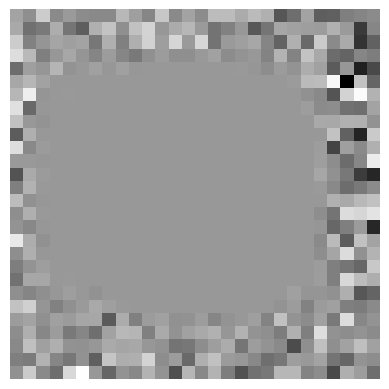

In [127]:
#print(x)
z=torch.randn(6,1,6,6)
z=z.to('cuda:0')
x=model.decoder(z)
print(x[0].shape)
x=x[0]
x=x.view(28,28)
#x=data[0].view(28,28)
x=x.to('cpu')
image_np = x.detach().numpy()

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()